In [1]:
# Step 1: Count files in each class (Train / Validation / Test)
import os

def total_files(folder_path):
    return sum([len(files) for _, _, files in os.walk(folder_path)])

train_path = r"C:\Users\Hp\Desktop\plant disease detection\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train"
valid_path = r"C:\Users\Hp\Desktop\plant disease detection\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\valid"
test_path  = r"C:\Users\Hp\Desktop\plant disease detection\test\test"

print("Total training images:", total_files(train_path))
print("Total validation images:", total_files(valid_path))
print("Total testing images:", total_files(test_path))


Total training images: 140590
Total validation images: 35144
Total testing images: 33


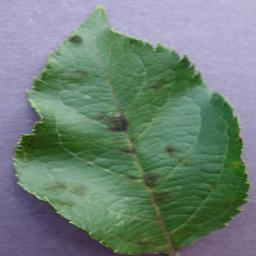

In [2]:
# Step 2: Show some sample images
from PIL import Image
import IPython.display as display

# Pick any one image from the training set
sample_image = os.path.join(train_path, os.listdir(train_path)[0], os.listdir(os.path.join(train_path, os.listdir(train_path)[0]))[0])

with open(sample_image, 'rb') as f:
    display.display(display.Image(data=f.read(), width=400))


In [3]:
# Step 3: Image Preprocessing and Augmentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(225, 225),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    valid_path,
    target_size=(225, 225),
    batch_size=32,
    class_mode='categorical'
)


Found 140590 images belonging to 38 classes.
Found 35144 images belonging to 38 classes.


In [4]:
# Step 4: Build the CNN Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(225, 225, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # prevent overfitting
model.add(Dense(38, activation='softmax'))  # 38 classes


In [5]:
# Step 5: Compile the Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
# Step 6: Train the Model
history = model.fit(
    train_generator,
    epochs=5,   # increase epochs for better results
    validation_data=validation_generator
)


Epoch 1/5
4394/4394 [==============================] - 12216s 3s/step - loss: 1.0322 - accuracy: 0.6860 - val_loss: 0.4200 - val_accuracy: 0.8660
Epoch 2/5
4394/4394 [==============================] - 35978s 8s/step - loss: 0.4971 - accuracy: 0.8430 - val_loss: 0.2840 - val_accuracy: 0.9051
Epoch 3/5
4394/4394 [==============================] - 11442s 3s/step - loss: 0.3775 - accuracy: 0.8806 - val_loss: 0.2046 - val_accuracy: 0.9322
Epoch 4/5
4394/4394 [==============================] - 11335s 3s/step - loss: 0.3163 - accuracy: 0.9002 - val_loss: 0.1726 - val_accuracy: 0.9435
Epoch 5/5
4394/4394 [==============================] - 11689s 3s/step - loss: 0.2780 - accuracy: 0.9126 - val_loss: 0.1996 - val_accuracy: 0.9384


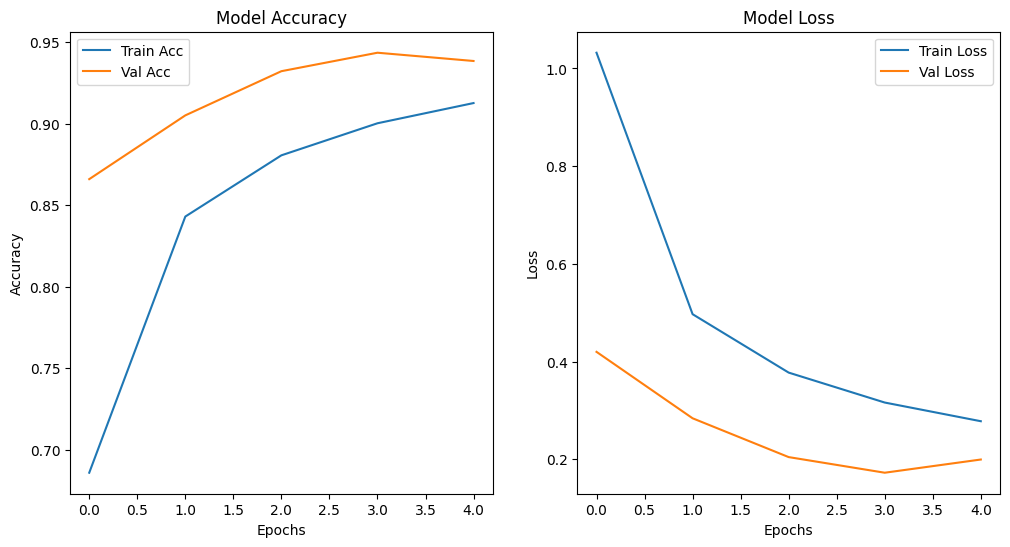

In [8]:
# Step 7: Plot Training Accuracy and Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [15]:
model.save("model.h5")

In [16]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Path to your test folder
test_path = r"C:\Users\Hp\Desktop\plant disease detection\test\test"

# Preprocessing function
def preprocess_image(image_path, target_size=(225, 225)):
    img = load_img(image_path, target_size=target_size)
    x = img_to_array(img)
    x = x.astype('float32') / 255.0
    x = np.expand_dims(x, axis=0)
    return x

# Pick one test image from the test folder (directly)
sample_test_image = os.path.join(test_path, os.listdir(test_path)[0])

# Preprocess and predict
x = preprocess_image(sample_test_image)
predictions = model.predict(x)

# Get label mapping from train generator
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}

# Predicted class
predicted_class = np.argmax(predictions, axis=1)
print("Predicted class:", class_labels[predicted_class[0]])


1/1 [==============================] - 0s 82ms/step
Predicted class: Apple___Cedar_apple_rust


In [17]:
# Save the class indices for later use in the Flask app
np.save('class_indices.npy', train_generator.class_indices)
